# DAO

## D.1 소개

* DAO Data Access Objects는 엔터프라이즈 패턴이다.
* J2EE 패턴으로 소개되었고, DB를 사용하는 어플리케이션에 널리 적용되고 있다 (참고: Sun Microsystems Inc., 2007, Core J2EE Patterns)
* 엔터프라이즈 패턴으로 업무와 DBMS를 분리하기 위해 사용한다.
* 업무와 데이터 2계층을 분리하고, 서로 그 상태를 동일하게 유지persistence하게 된다.
    * business layer: 고객, 주문, 유통과 같은 업무 절차 및 규칙
    * data access layer: 정보를 어떻게 저장할 것인지, 예를 들어 고객ID는 몇 자리로 할 것인지, 숫자 또는 문자인지 등 물리적인 문제

* 디자인패턴 요소

요소 | 설명
---|---
name | Dao
problem | DB를 사용하는 방법이 변경되면 클라이언트의 수정이 많아진다.
solution | 사용방법의 분리
consequence | loose coupling, 확장성

* 프로그래밍 예제
    * 과제
        * 주소록을 DAO패턴을 사용하여 CRUD
        * master-detail

## D.2 문제

* 데이터를 저장하는 방식이 다양하다 (데이터베이스, 파일, XML, csv 등)
* 사용하는 방법이 다르게 되면 변경이 많아지게 된다. DMBS에 따라 Sql이 서로 다를 수 있다.
* 데이터를 저장하는 방식을 분리하여, 변경을 최소화한다.

## D.3 설계

역할 | 설명
-----|-----
Dao | 모델에 대한 기본적인 CRUD 인터페이스
DaoImpl | Dao 인터페이스 구현 (실제 연결한 DBMS, sql)
Value Object (또는 Model Object) | Dao를 사용하여 데이터를 저장하는 단순 POJO

In [1]:
import iplantuml

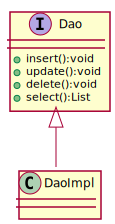

In [2]:
%%plantuml

@startuml

interface Dao {
    +insert():void    
    +update():void
    +delete():void
    +select():List
}
class DaoImpl
Dao <|.. DaoImpl
@enduml

## D.4 사례

### D.4.1 주소록 사용사례

* CRUD기능을 구현한다.
* Use Case: 주소록 관리
    * Basic Flow:
        * 1) 사용자가 주소록 (이름, 주소) 조회를 요청.
            * 단건조회
            * 목록조회
        * 2) 사용자가 입력을 요청.
        * 3) 사용자가 수정을 요청.
            * 데이터가 존재하는지 확인
        * 4) 사용자가 삭제를 요청.
            * 데이터가 존재하는지 확인
    * Alternative Flow:
        * 1-1a) DB연결 오류: "DB 연결 오류" 출력. 
        * 1-1b) 데이터가 존재하지 않는 경우: "데이터가 존재하지 않습니다" 출력. 
        * 2-1) 특수문자가 있는 경우: "특수문자 입력 오류" 출력. 
        * 3-1) 데이터 존재하지 않는 경우: "입력 오류" 출력. 

* 버전

구분 | 설명
-----|-----
v0 | simple JDBC 사례 - MySql, DAO 구현하지 않는다.
v1 | List, DAO
v2 | MySql, DAO, 수정, 삭제, 단건조회, 목록조회 (master-detail)


* Properties
    * 비밀번호는 properties에 저장하여 사용한다.
```
USER=
PASSWORD=
```

In [7]:
!ls -l src/mysql.properties

-rw-rw-r-- 1 jsl jsl 55  5월 17 10:00 src/mysql.properties


* jdbc connector를 설치한다.
    * mysql connector 다운로드 http://dev.mysql.com/downloads/connector/j
    * 압축을 풀면 mysql-connector-XXX.jar
    * classpath에 추가한다.

In [5]:
!ls -l /usr/share/java/mysql*

-rw-r--r-- 1 root root 987191  2월  7  2016 /usr/share/java/mysql-connector-java-5.1.38.jar
lrwxrwxrwx 1 root root     31  2월  7  2016 /usr/share/java/mysql-connector-java.jar -> mysql-connector-java-5.1.38.jar
lrwxrwxrwx 1 root root     24  2월  7  2016 /usr/share/java/mysql.jar -> mysql-connector-java.jar


### v0  simple JDBC

* DAO 패턴을 사용하지 않고, 데이터를 입력, 수정, 삭제, 조회
* 실행하면서 useSSL 'WARN' 메시지가 발생하면
    * "?useSSL=false"를 추가한다.

In [ ]:
# %load src/com/sd/dao/v0/DaoMainV0.java

package com.sd.dao.v0;
import java.sql.*;
import java.util.Properties;
import java.io.FileInputStream;
import java.io.FileNotFoundException;
import java.io.IOException;

public class DaoMainV0 {
    public static void main (String[] args){
        String path = System.getProperty("user.dir");
        path += "/src/mysql.properties";
        Properties prop = new Properties();
        try {
            FileInputStream fin = new FileInputStream(path);
            prop.load(fin);
            Class.forName("com.mysql.jdbc.Driver");
            Connection conn = DriverManager.getConnection(
                prop.getProperty("URL")+"?useSSL=true",
                prop.getProperty("USER"),
                prop.getProperty("PASSWORD")
            );
            String mySql="CREATE TABLE persons(id int(64) NOT NULL AUTO_INCREMENT,";
            mySql+="name varchar(255) NOT NULL, address varchar(255) NOT NULL, UNIQUE (id))";
            conn.createStatement().execute(mySql);
            //conn.createStatement().execute("INSERT INTO persons(name,address) VALUES('js1','1 Hongji Dong')");
            //conn.createStatement().execute("INSERT INTO persons(name,address) VALUES('js2','2 Hongji Dong')");
            //conn.createStatement().execute("INSERT INTO persons(name,address) VALUES('js3','3 Hongji Dong')");

            //conn.createStatement().execute("DELETE FROM persons WHERE id=3 LIMIT 1");

            //ResultSet rs = conn.createStatement().executeQuery("SELECT name FROM persons WHERE id < 4 ORDER BY id");
            //while (rs.next() == true){
            //    System.out.println(rs.getString("name"));
            //}
            //rs.close();
            conn.close();
        }
        catch (Exception e){
            e.printStackTrace();
        }
    }
}

In [ ]:
!javac -d classes/ -sourcepath src/ src/com/sd/dao/v0/DaoMainV0.java
!java -cp classes/:/usr/share/java/mysql.jar com.sd.dao.v0.DaoMainV0

* 실행하고 mysql cli로 확인한다.

```
mysql> use test;
Database changed
mysql> show tables;
+----------------+
| Tables_in_test |
+----------------+
| persons        |
+----------------+

mysql> 
```

#### v1 LIST DAO (no JDBC)

* List로 구현해서 DAO를 사용한다. JDBC를 사용하지 않는다.
    * List는 추상클래스, ArrayList를 생성한다.
    * List에서 데이터를 가져오려면 인덱스. a.get(0)
    * 삭제는 remove(0)

In [1]:
List a = new List()

 List a = new List()
|  Error:
|  java.util.List is abstract; cannot be instantiated
|  List a = new List();
|           ^--------^



In [3]:
List a = new ArrayList()
a.add("a")
a.get(0)


 List a = new ArrayList()
|  Modified variable a of type List with initial value []
|    Update overwrote variable a

 a.add("a")
|  Warning:
|  unchecked call to add(E) as a member of the raw type java.util.List
|  a.add("a")
|  ^--------^
|  Expression value is: true
|    assigned to temporary variable $4 of type boolean

 a.get(0)
|  Expression value is: "a"
|    assigned to temporary variable $5 of type Object



In [ ]:
# %load src/com/sd/dao/v1/Person.java
package com.sd.dao.v1;
public class Person {
    private int id;
    private String name;
    Person(int id, String name){
        this.id=id;
        this.name=name;
    }
    public String getName() {
        return name;
    }
    public void setName(String name) {
        this.name=name;
    }
    public int getId() {
        return id;
    }
    public void setId(int id) {
        this.id=id;
    }
}

In [ ]:
# %load src/com/sd/dao/v1/PersonDao.java
package com.sd.dao.v1;
import java.util.List;

public interface PersonDao {
    public List<Person> getAllPersons();
    public Person getPerson(int id);
    public void updatePerson(Person p);
    public void deletePerson(Person p);
}


In [ ]:
# %load src/com/sd/dao/v1/PersonDaoImpl.java
package com.sd.dao.v1;
import java.util.ArrayList;
import java.util.List;

public class PersonDaoImpl implements PersonDao {
    List<Person> persons;
    public PersonDaoImpl() {
        persons = new ArrayList<Person>();
        Person p1 = new Person(0,"js1");
        Person p2 = new Person(1,"js2");
        persons.add(p1);
        persons.add(p2);           
    }
    public void deletePerson(Person p) {
        persons.remove(p.getId());
        System.out.println("deleting... "+p.getId());
    }
    public List<Person> getAllPersons() {
        return persons;
    }
    public Person getPerson(int rollNo) {
        return persons.get(rollNo);
    }
    public void updatePerson(Person person) {
        persons.get(person.getId()).setName(person.getName());
        System.out.println("updating... "+person.getId());
    }
}


In [ ]:
# %load src/com/sd/dao/v1/DaoMainV1.java
package com.sd.dao.v1;

public class DaoMainV1 {
   public static void main(String[] args) {
      PersonDao personDao = new PersonDaoImpl();
      System.out.println("--- listing all...");
      for (Person person:personDao.getAllPersons()) {
         System.out.println("reading... "+person.getId() +", "+person.getName());
      }

      System.out.println("--- updating...");
      Person person =personDao.getAllPersons().get(0);
      person.setName("js new");
      personDao.updatePerson(person);

      System.out.println("--- see if updated...");
      personDao.getPerson(0);
      System.out.println(person.getId() +", "+person.getName());
   }
}


In [ ]:
!javac -d classes/ -sourcepath src/ src/com/sd/dao/v1/DaoMainV1.java
!java com.sd.dao.v1.DaoMainV1

#### v2 MySql DAO

* v0에서 'persons' 테이블이 생성되어 있어야 한다.
* PreparedStatment vs Statement
    * 동적으로 Sql문을 만들 수 있다.
* boolean execute() - any kind of SQL statement.
* ResultSet executeQuery() the ResultSet object generated by the query.
* int executeUpdate() SQL INSERT, UPDATE or DELETE statement; or an SQL statement that returns nothing, such as a DDL statement.

* CRUD 함수의 예
```
public void insert(Customer customer) throws CustomerDAOException;
public void update(CustomerPK pk, Customer customer) throws CustomerDAOException;
public void delete(CustomerPK pk) throws CustomerDAOException;
public Customer[] findAll() throws CustomerDAOException;
public Customer findByPrimaryKey(String email) throws CustomerDAOException;
public Customer[] findByCompany(int companyId) throws CustomerDAOException;
```

In [1]:
/classpath /usr/share/java/mysql.jar
/classpath classes/

 /classpath /usr/share/java/mysql.jar
|  Path '/usr/share/java/mysql.jar' added to classpath

 /classpath classes/
|  Path 'classes/' added to classpath



In [2]:
import java.sql.Connection;
import com.sd.dao.v2.*;
Connection conn=ConnectionFactory.getConnection();

 import java.sql.Connection;

 import com.sd.dao.v2.*;
|    Update modified method printf(String,Object...)

 Connection conn=ConnectionFactory.getConnection();
DB connecting...jdbc:mysql://localhost/test
|  Added variable conn of type Connection with initial value com.mysql.jdbc.JDBC4Connection@36f0f1be



In [4]:
import java.sql.ResultSet;
import java.sql.Statement;
Statement statement = conn.createStatement();
ResultSet rs = statement.executeQuery("SELECT * FROM persons");
while (rs.next()) {
    System.out.println(rs.getInt(1)+"\t"+rs.getString(2));
}

 import java.sql.ResultSet;

 import java.sql.Statement;

 Statement statement = conn.createStatement();
|  Modified variable statement of type Statement with initial value com.mysql.jdbc.StatementImpl@568bf312
|    Update overwrote variable statement

 ResultSet rs = statement.executeQuery("SELECT * FROM persons");
|  Modified variable rs of type ResultSet with initial value com.mysql.jdbc.JDBC42ResultSet@ca263c2
|    Update overwrote variable rs

 while (rs.next()) {
     System.out.println(rs.getInt(1)+"\t"+rs.getString(2));
 }
39	js1
40	js2



In [5]:
ConnectionFactory.closeConnection();

 ConnectionFactory.closeConnection();
DB closing...



In [ ]:
# %load src/com/sd/dao/v2/ConnectionFactory.java
package com.sd.dao.v2;

import java.sql.Connection;
import java.sql.DriverManager;
import java.sql.SQLException;
import java.util.Properties;
import java.io.FileInputStream;
import java.io.FileNotFoundException;
import java.io.IOException;

public class ConnectionFactory {
    private static Connection conn=null;
    private ConnectionFactory() {}
    public static Connection getConnection(){
        String path = System.getProperty("user.dir");
        path += "/src/mysql.properties";
        Properties prop = new Properties();
        try {
            prop.load(new FileInputStream(path));
            Class.forName("com.mysql.jdbc.Driver");
            if(conn == null)
                conn = DriverManager.getConnection(
                    prop.getProperty("URL")+"?useSSL=true",
                    prop.getProperty("USER"),
                    prop.getProperty("PASSWORD")
                );
            System.out.println("DB connecting..."+prop.getProperty("URL"));
        } catch (IOException e) {
            e.printStackTrace();
        } catch (ClassNotFoundException e) {
            e.printStackTrace();
        } catch (SQLException e) {
            e.printStackTrace();
        }
        return conn;
    }
    public static void closeConnection() {
        try {
            if (conn != null) {
                System.out.println("DB closing...");
                conn.close();
            }
        } catch (Exception e) {
            e.printStackTrace();
        }
    }
}


In [ ]:
# %load src/com/sd/dao/v2/PersonVO.java
package com.sd.dao.v2;

public class PersonVO {
    private int id;
    private String name;
    private String address;
    public int getId() {
        return id;
    }
    public void setId(int id) {
        this.id = id;
    }
    public String getName() {
        return name;
    }
    public void setName(String name) {
        this.name = name;
    }
    public String getAddress() {
        return address;
    }
    public void setAddress(String address) {
        this.address = address;
    }
    public String toString(){
        return "ID: "+id+" Name: "+name+" Address: "+address;
    }
}

In [ ]:
# %load src/com/sd/dao/v2/PersonDAO.java
package com.sd.dao.v2;

import java.util.List;

public interface PersonDAO {
    public void insert(PersonVO person);
    public List<PersonVO> findAll();
    public PersonVO findById(int id);
    public void update(PersonVO person);
    public void delete(int id);
}


In [ ]:
# %load src/com/sd/dao/v2/PersonDAOImpl.java
package com.sd.dao.v2;

import java.sql.Connection;
import java.sql.DriverManager;
import java.sql.PreparedStatement;
import java.sql.ResultSet;
import java.sql.SQLException;
import java.sql.Statement;
import java.util.ArrayList;
import java.util.List;
import java.util.Properties;
import java.io.FileInputStream;
import java.io.FileNotFoundException;
import java.io.IOException;

public class PersonDAOImpl implements PersonDAO {
    Connection conn=ConnectionFactory.getConnection();

    public void insert(PersonVO person) {
        try {
            PreparedStatement pstmt = conn.prepareStatement("INSERT INTO persons(id,name,address) VALUES(NULL,?,?)");
            pstmt.setString(1, person.getName());
            pstmt.setString(2, person.getAddress());
            System.out.println("inserting..."+person.getName()+person.getAddress());
            pstmt.executeUpdate();
            pstmt.close();
        } catch (SQLException e) {
            e.printStackTrace();
        }
    }
    public PersonVO findById(int id) {
        PersonVO person=null;
        try {
            PreparedStatement pstmt = conn.prepareStatement("SELECT * FROM persons WHERE id=?");
            pstmt.setInt(1, id);
            System.out.println("finding by id..."+id);
            ResultSet rs = pstmt.executeQuery();
            if(rs.next()) {
                person = new PersonVO();
                person.setId(rs.getInt("id"));
                person.setName(rs.getString("name"));
                person.setAddress(rs.getString("address"));
                pstmt.close();
            }
        } catch (SQLException e) {
            e.printStackTrace();
        }
        return person;
    }
    public List<PersonVO> findAll() {
        List<PersonVO> persons = new ArrayList<PersonVO>();
        try {
            Statement statement = conn.createStatement();
            ResultSet rs = statement.executeQuery("SELECT * FROM persons");
            PersonVO person = null;
            while(rs.next()){
                person = new PersonVO();
                //person.setId(Integer.parseInt(rs.getString("id")));
                person.setId(rs.getInt("id"));
                person.setName(rs.getString("name"));
                person.setAddress(rs.getString("address"));
                persons.add(person);
            }
            rs.close();
            statement.close();
        } catch (SQLException e) {
            e.printStackTrace();
        }
        System.out.println("finding all..."+persons);
        return persons;
    }
    public void update(PersonVO person) {
        try {
            PreparedStatement pstmt = conn.prepareStatement("UPDATE persons SET name=?,address=? WHERE id=?"); 
            pstmt.setString(1, person.getName());
            pstmt.setString(2, person.getAddress());
            pstmt.setInt(3, person.getId());
            System.out.println("updating..."+person.getName());
            pstmt.executeUpdate();
            pstmt.close();
        } catch (SQLException e) {
            e.printStackTrace();
        }
    }
    public void delete(int id) {
        try {
            PreparedStatement pstmt = conn.prepareStatement("DELETE FROM persons WHERE id=?");
            pstmt.setInt(1, id);
            System.out.println("deleting..."+id);
            pstmt.executeUpdate();
            pstmt.close();
        } catch (SQLException e) {
            e.printStackTrace();
        }
    }
}


In [ ]:
# %load src/com/sd/dao/v2/DaoMainV2.java
package com.sd.dao.v2;

import java.util.List;
import java.util.Iterator;

public class DaoMainV2 {
    public static void main(String args[]){
        PersonDAOImpl personDAOImpl = new PersonDAOImpl();
        PersonVO person = new PersonVO();

        person.setName("js1");
        person.setAddress("1 Hongji-dong");
        personDAOImpl.insert(person);

        person.setName("js2");
        person.setAddress("2 Hongji-dong");
        personDAOImpl.insert(person);

        List persons=personDAOImpl.findAll();
        Iterator iter=persons.iterator();
        while(iter.hasNext()) {
            person=(PersonVO)iter.next();
            System.out.println(person.toString());
        }

        personDAOImpl.delete(1);

        person.setId(2);
        person.setName("js2 updated");
        person.setAddress("2 Hongji-dong updated");
        personDAOImpl.update(person);

        person=personDAOImpl.findById(2);
        System.out.println("found by id..."+person);

        ConnectionFactory.closeConnection();
    }
}


In [ ]:
!javac -d classes/ -sourcepath src/ src/com/sd/dao/v2/*.java
java -cp classes/:/usr/share/java/mysql.jar com.sd.dao.v2.DaoMainV2 

* mysql cli로 확인
```
$ mysql -u root -p
mysql> use test;
mysql> select * from persons;
+----+--------------+---------------+
| id | name         | address       |
+----+--------------+---------------+
|  1 | js1          | 1 Hongji-dong |
|  1 | js2          | 2 Hongji-dong |
+----+--------------+---------------+
```